# Ensembles
## Carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns

df = pd.read_csv('data/titanic_modified.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   MissingAge  891 non-null    int64  
 7   Spouse      891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 55.8 KB


In [3]:
from sklearn.model_selection import train_test_split

classes = list(df.loc[:, 'Pclass':].columns)

X = df.loc[:, 'Pclass':].values
y = df['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state=55)

## Voting classifier
1. Primero declaramos todos los clasificadores que participarán en el voting classifier.
2. A continuación agrupamos los estimadores en una lista de tuplas, con sus identificadores.
3. Declaramos el VotingClassifier

En primer lugar, probaremos un `hard` VotingClassifier, es decir, tendrá en cuenta las predicciones de los clasificadores, no sus probabilidades.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

'''
Por defecto coge soft voting, si pueden todos los clasificadores.
En el caso del SVM tiene que realizar una validación cruzada ya que
no soporta el predict_proba()
'''

log_clf = LogisticRegression(random_state=42) # Mezcla los datos
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42) # Se usa en combinación con otro arg
svm_clf = SVC(gamma="scale", random_state=42)

estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)]

voting_clf = VotingClassifier(estimators=estimators, voting='hard')

In [5]:
# Train the model
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Vemos los aciertos (accuracy score) de todos los clasificadores + el voting classifier

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7988826815642458
RandomForestClassifier 0.7932960893854749
SVC 0.6145251396648045
VotingClassifier 0.8044692737430168


Probaremos ahora con el `soft` VotingClassifier, es decir, teniendo e cuenta las probabilidades, no los votos.

In [7]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) # PROBABILITY = TRUE

estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)]

soft_voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Train the model
soft_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
for clf in (log_clf, rnd_clf, svm_clf, soft_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7988826815642458
RandomForestClassifier 0.7932960893854749
SVC 0.6145251396648045
VotingClassifier 0.8044692737430168


## Bagging Classifier
Sistema de clasificación por votación de algoritmos. En este caso siempre es el mismo tipo de algoritmo, habitualmente árboles de decisión.

El siguiente ejemplo sería un algoritmo muy similar a un RandomForest.

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(max_depth=3,random_state=42)

bag_clf = BaggingClassifier(
    base_estimator = estimator,
    n_estimators=500, # Cantidad de árboles
    max_samples=100, # Muestras utilizadas en boostrapping
    bootstrap=True, # Usamos boostrapping
    # max_features = 3, # Features que utiliza en el boostrapping. Cuanto más bajo, mejor generalizará y menos overfitting
    random_state=42)


bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8100558659217877

Mejor que un DecisionTree por separado

In [17]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.776536312849162


## Random Forest

Los RandomForest cuentan con todos los hiperparámetros de un DecissionTree y los de un algoritmo de Bagging.

**RandomForestClassifier**

In [20]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
# np.sum(y_test == y_pred_rf) / len(y_test) 
accuracy_score(y_test, y_pred_rf)

0.8100558659217877

Mejor que el Bagging Classifier, al llevar parámetros por defecto aplicados al DecisionTree que funcionan mejor para estos datos.

Veamos el feature importance. En cada split de los árboles se calcula el IG (Information Gained) teniendo en cuenta la entropía antes y después del split. Se realiza una ponderación del IG en cada spllit, teniendo en cuenta la feature del split y con ello sklearn consigue el feature importance

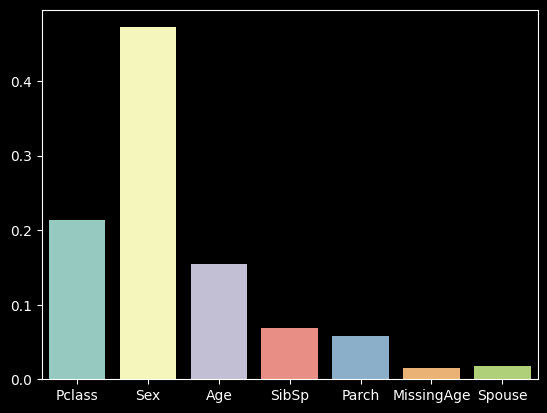

In [21]:
sns.barplot(x=classes, y=rnd_clf.feature_importances_);

Ejemplo de feature importance en imagenes

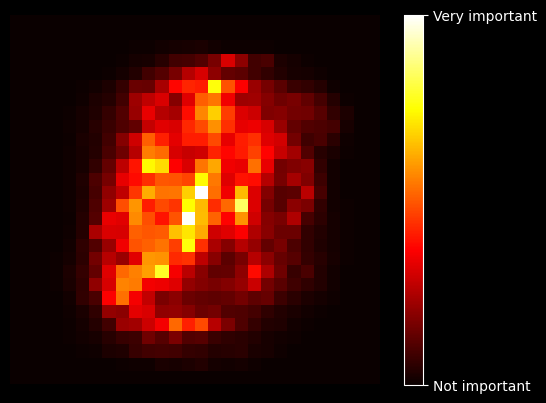

In [22]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

In [23]:
mnist["data"].shape

(70000, 784)

**¿Qué hiperparámetros debería tocar en el RandomForest?**
1. `n_estimators`: número de árboles que participarán en las votaciones. Cuantos más mejor. NO producen overfitting. Cuanto más complejo es el dataset, mejor vendrá que haya muchos árboles. Más de 200 suele ser redundante.
2. `max_depth`: profundida de los árboles. Cuanto más profundos, más complejo es el modelo, pero menos generaliza. De  nuevo, cuanto más complejo es el problema, mayor profundidad necesitaremos. No más de 20/30 es lo normal.
3. `max_features`: features a tener en cuenta en los splits del árbol. Cuanto más bajo, mejor generalizará y menos overfitting. Numero menor a la cantidad de features del dataset, sino dará error.
4. `min_samples_split`: mínima cantidad de muestras en un nodo antes de ser spliteado. 2 por defecto. Números bajos suelen dar buenos resultados (<50). Cuanto más alto, mejor generaliza, pero más baja la precisión.
5. `min_samples_leaf`: mínima cantidad de puntos permitidos en un `leaf node`, es decir, un nodo que no va a volver a ser spliteado. Valores bajos funcionan bien (<50).


**RandomForestRegressor**

In [25]:
df_reg = pd.read_csv('data/USA_Housing.csv')

X_reg = df_reg.loc[:, 'Avg. Area Income': 'Area Population'].values
Y_reg = df_reg['Price'].values
df_reg.head(2)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\r\nLaurabury, NE 37..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\r\nLake Kathleen, ..."


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rnd_reg = RandomForestRegressor(n_estimators=500,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_reg.fit(X_reg, Y_reg)

y_pred_reg = rnd_reg.predict(X_reg)
print(mean_absolute_error(Y_reg, y_pred_reg))
print(mean_squared_error(Y_reg, y_pred_reg)**(1/2))
print(r2_score(Y_reg, y_pred_reg))

147827.0018536551
187437.2429021338
0.718187762051737


## AdaBoost

**AdaBoostClassifier**

In [32]:
from sklearn.ensemble import AdaBoostClassifier

estimator = DecisionTreeClassifier(max_depth=1)

ada_clf = AdaBoostClassifier(base_estimator = estimator,
                             n_estimators=200,
                             learning_rate=0.5,
                             random_state=42)

ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7932960893854749

También tenemos feature importance

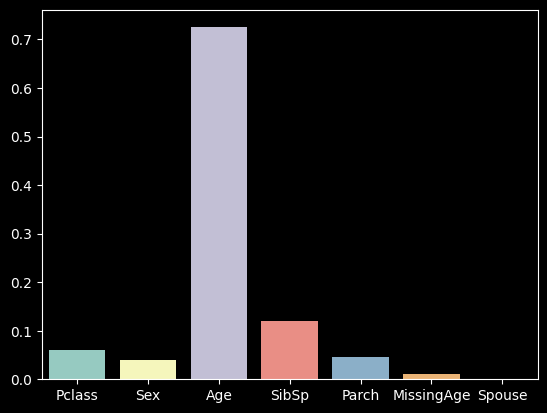

In [33]:
sns.barplot(x=classes, y=ada_clf.feature_importances_);

**¿Qué hiperparámetros debería tocar en el AdaBoostClassifier?**
1. `n_estimators`: número de árboles que participarán en la corrección secuencial del error del modelo. Si corregimos el error a la perfección el algoritmo termina de entrenar. Cuantos más estimadores, mejor corregiremos el error pero mayor probabilidad de caer en overfitting. Valores superiores a 100 suelen sobreajustar el modelo aunque dependerá de la complejidad y volumen de los datos.
2. `learning_rate`: no suele tener valores superiores a 1. Cuanto más alto, más aporta cada nuevo árbol, más preciso, pero caemos en overfitting. **Importante**: un learning rate bajo y alto número de estimadores no necesariamente tiene por qué aumentar la precisión y si va a inducir en altos costes computacionales.
3. `algorithm`: 'SAME' o 'SAME.R'. 'SAME.R' utiliza la probabilidad para actualizar los modelos aditivos, mientras que 'SAME' usa los valores de clasificación. Similar a soft vs hard voting. 'SAMME.R' converge antes que 'SAMME'
4. `base_estimator`: se suele dejar por defecto, aunque podría encajar un SVM o una RegresiónLogística
5. `max_depth`: **OJO**, no es un hiperparámetro del AdaBoostClassifier, sino del DecisionTreeClassifier. Habrá que probar varios árboles con diferentes `max_depth` y después ponerlos como `base_estimator` en el AdaBoost. Cuanto mayor es este hiperparámetro, más preciso, pero también más overfitting.

**AdaBoostRegressor**

In [34]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators=200,
                            random_state=42)
ada_reg.fit(X_reg, Y_reg)

y_pred_ada_reg = ada_reg.predict(X_reg)
mean_absolute_error(Y_reg, y_pred_ada_reg)

100809.79130779192

## GradientBoosting

**GradientBoostingRegressor**

El GradientBoosting funciona sólo con árboles, por eso no es posible cambiar el estimador. Directamente los hiperparámetros a configurar en en GradientBoosting son los del DecissionTree.

En este caso, vamos a probar primero con un regresor, que se entiende mejor.

In [35]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [37]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [38]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [39]:
X_new = np.array([[0.8]])

In [40]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [41]:
y_pred

array([0.75026781])

In [47]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

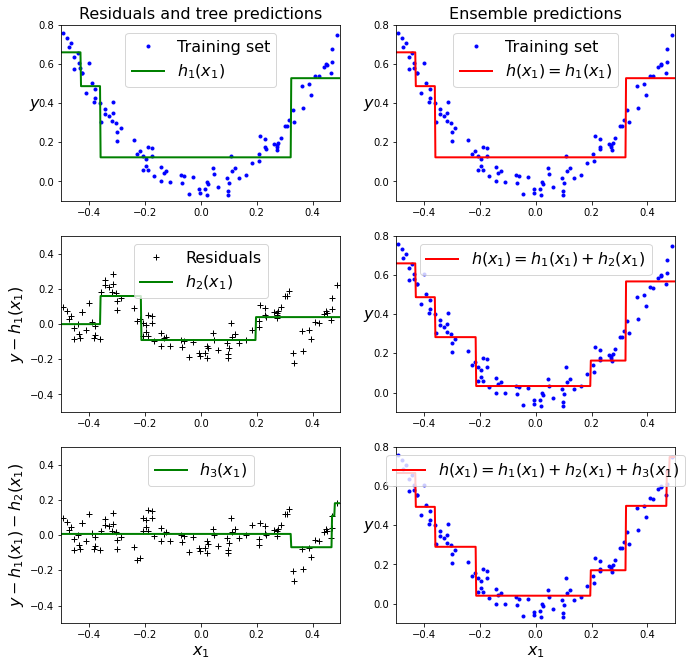

In [48]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0,
                                 random_state=42)
gbrt.fit(X_reg, Y_reg)


y_pred_gbrt = gbrt.predict(X_reg)
mean_absolute_error(Y_reg, y_pred_gbrt)

158608.16086318

**GradientBoostingClassifier**

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

gbct = GradientBoostingClassifier(max_depth=2,
                                 n_estimators=100,
                                 learning_rate=1.0,
                                 random_state=42)
gbct.fit(X_train, y_train)


y_pred_gbct = gbct.predict(X_test)
accuracy_score(y_test, y_pred_gbct)

0.8100558659217877

**¿Qué hiperparámetros debería tocar en el GradientBoosting?**
1. `n_estimators`: número de árboles que participarán en la corrección secuencial del error del modelo. Si corregimos el error a la perfección el algoritmo termina de entrenar. Cuantos más estimadores, mejor corregiremos el error pero mayor probabilidad de caer en overfitting. Valores superiores a 100 suelen sobreajustar el modelo aunque dependerá de la complejidad y volumen de los datos.
2. `learning_rate`: no suele tener valores superiores a 1. Cuanto más alto, más aporta cada nuevo árbol, más preciso, pero caemos en overfitting. **Importante**: un learning rate bajo y alto número de estimadores no necesariamente tiene por qué aumentar la precisión y si va a inducir en altos costes computacionales.
3. `max_depth`: Cuanto mayor es este hyperparámetro, más preciso, pero también más overfitting.

Se puede iterar sobre todos los hiperparámetros recorridos en el RandomForest

## XGBoost

**XGBRegressor**

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

XGBoost permite regularizar el modelo, puede manejar missings, por lo que no es necesario tener el dataset perfectamente limpio

In [ ]:
#!pip install xgboost

In [44]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)

xgb_reg.fit(X_reg, Y_reg)
y_pred = xgb_reg.predict(X_reg)
mean_absolute_error(Y_reg, y_pred) 

43347.53348686592

In [45]:
xgb_clas = xgboost.XGBRFClassifier(random_state=42)

xgb_clas.fit(X_train, y_train)
y_pred = xgb_clas.predict(X_test)
accuracy_score(y_test, y_pred)

0.8156424581005587

**¿Qué hiperparámetros debería tocar en el XGB?**
1. `n_estimators`: igual que para el GradientBoosting.
2. `booster`: tipo de modelo que correrá en cada iteración. Arboles o regresiones. `gbtree` or `gblinear`. Los árboles suelen ir bien.
3. `learning_rate`: o también llamado `eta`. Como el learning rate del GradientBoosting.
4. `max_depth`: nada nuevo

Si quieres afinar más todavía el XGBoost consulta [esta completa guía](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In [46]:
pip install catboost


     -------------------------------------- 101.0/101.0 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import catboost

xgb_reg = catboost.CatBoostRegressor(random_state=42)

xgb_reg.fit(X_reg, Y_reg)
y_pred = xgb_reg.predict(X_reg)
mean_absolute_error(Y_reg, y_pred) 

Learning rate set to 0.052798
0:	learn: 341618.6883263	total: 396ms	remaining: 6m 35s
1:	learn: 330764.3378042	total: 418ms	remaining: 3m 28s
2:	learn: 320810.8530185	total: 431ms	remaining: 2m 23s
3:	learn: 310669.1373831	total: 463ms	remaining: 1m 55s
4:	learn: 301324.2682752	total: 471ms	remaining: 1m 33s
5:	learn: 291877.5401154	total: 479ms	remaining: 1m 19s
6:	learn: 283193.5394697	total: 504ms	remaining: 1m 11s
7:	learn: 274707.0696581	total: 519ms	remaining: 1m 4s
8:	learn: 266815.4896633	total: 532ms	remaining: 58.6s
9:	learn: 258999.4689661	total: 545ms	remaining: 54s
10:	learn: 251867.7068682	total: 554ms	remaining: 49.8s
11:	learn: 244866.8680888	total: 563ms	remaining: 46.3s
12:	learn: 238384.6529828	total: 575ms	remaining: 43.6s
13:	learn: 232053.7692774	total: 611ms	remaining: 43s
14:	learn: 226210.1083093	total: 634ms	remaining: 41.7s
15:	learn: 220449.0297242	total: 641ms	remaining: 39.4s
16:	learn: 214849.6317581	total: 647ms	remaining: 37.4s
17:	learn: 209635.9742790

63166.91283982816

In [48]:
xgb_clas = catboost.CatBoostClassifier(random_state=42)

xgb_clas.fit(X_train, y_train)
y_pred = xgb_clas.predict(X_test)
accuracy_score(y_test, y_pred)


Learning rate set to 0.008911
0:	learn: 0.6880721	total: 10.7ms	remaining: 10.7s
1:	learn: 0.6847118	total: 12.9ms	remaining: 6.42s
2:	learn: 0.6794068	total: 15ms	remaining: 5s
3:	learn: 0.6740718	total: 17.7ms	remaining: 4.41s
4:	learn: 0.6679044	total: 20.3ms	remaining: 4.05s
5:	learn: 0.6631298	total: 22.3ms	remaining: 3.69s
6:	learn: 0.6579282	total: 25.4ms	remaining: 3.6s
7:	learn: 0.6531104	total: 28ms	remaining: 3.47s
8:	learn: 0.6482386	total: 30ms	remaining: 3.31s
9:	learn: 0.6450419	total: 32.4ms	remaining: 3.21s
10:	learn: 0.6400555	total: 54.9ms	remaining: 4.94s
11:	learn: 0.6351652	total: 57.7ms	remaining: 4.75s
12:	learn: 0.6304302	total: 60.7ms	remaining: 4.6s
13:	learn: 0.6260697	total: 65.4ms	remaining: 4.61s
14:	learn: 0.6213343	total: 68.2ms	remaining: 4.48s
15:	learn: 0.6170068	total: 74.4ms	remaining: 4.57s
16:	learn: 0.6126812	total: 83.1ms	remaining: 4.8s
17:	learn: 0.6082963	total: 85.7ms	remaining: 4.67s
18:	learn: 0.6041403	total: 88ms	remaining: 4.54s
19:	le

0.8100558659217877